In [172]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from gymnasium import spaces
from collections import deque
import math

Testing the algorithm with RandomWalk.


In [173]:
class RandomWalkEnv(gym.Env):
    """
    Initializes a series of `size` states *including* the two terminal states.
    There are no actions.
    Args:
        size (int): The size of the random walk environment.
    """

    def __init__(self, size):
        super().__init__()

        self.n_states = size

        self.observation_space = spaces.Discrete(size)
        self.action_space = spaces.Discrete(1)

    def reset(self):
        self.state = self.n_states // 2
        return self.state, {}

    def step(self, action):
        s = self.state
        s += 1 if np.random.rand() < 0.5 else -1
        terminated = s == 0 or s == self.n_states - 1
        reward = -1 if s == 0 else 1 if s == self.n_states - 1 else 0
        self.state = s
        return s, reward, terminated, False, {}

In [225]:
np.empty(3)[0]
np.array([1, 2]) + np.array([1, 2])

array([2, 4])

In [245]:
# n-step TD using the n-step error (n real rewards plus bootstrapping)
def with_n_step_error(env: gym.Env, episodes, record_err_per, n, alpha, gamma):
    # value estimations (running)
    vs = np.zeros(env.n_states)
    # root mean squared errors
    rmse = np.empty(episodes // record_err_per)

    for ep in range(episodes):
        # previous n states
        ss = deque()
        # previous n rewards
        rs = deque()

        s, _ = env.reset()
        ss.append(s)

        done = False
        while not done:
            s, r, done, _, _ = env.step(None)
            rs.append(r)

            # n rewards accumulated, update the state n steps ago
            if len(rs) == n:
                s_old = ss.popleft()
                g = 0
                gamma_pow = 1
                for r in rs:
                    g += gamma_pow * r
                    gamma_pow *= gamma
                g += gamma_pow * vs[s]
                vs[s_old] += alpha * (g - vs[s_old])
                rs.popleft()

            ss.append(s)

        # episode ended, but the last n rewards are pending
        while len(rs) > 0:
            s_old = ss.popleft()
            g = 0
            gamma_pow = 1
            for r in rs:
                g += gamma_pow * r
                gamma_pow *= gamma
            vs[s_old] += alpha * (g - vs[s_old])
            rs.popleft()

        if ep % record_err_per == 0:
            index = ep // record_err_per
            error = 0
            for i in range(1, env.n_states - 1):
                v_star = 2 * i / (env.n_states - 1) - 1
                # print(f"for state {i}, {v_star=}")
                error += (vs[i] - v_star) ** 2
            error /= env.n_states - 2
            error = math.sqrt(error)
            rmse[index] = error

    return vs, rmse

In [ ]:
# Evaluation the algorithm using the given set of hyperparameters.
# Average RMS error over x runs
def evaluate(env, episodes, record_err_per, runs=10, n=1, alpha=0.1, gamma=1.0):
    vs_total = np.zeros(env.n_states)
    rmse_total = np.zeros(episodes // record_err_per)
    for run in range(runs):
        vs, rmse = with_n_step_error(env, episodes, record_err_per, n, alpha, gamma)
        vs_total += vs
        rmse_total += rmse

    vs_avg = vs_total / runs
    rmse_avg = rmse_total / runs

    return vs_avg, rmse_avg

In [283]:
env = RandomWalkEnv(9)
episodes = 50
record_err_per = 5
vs, rmse = evaluate(env, episodes, record_err_per, n=4, alpha=0.1, gamma=1)

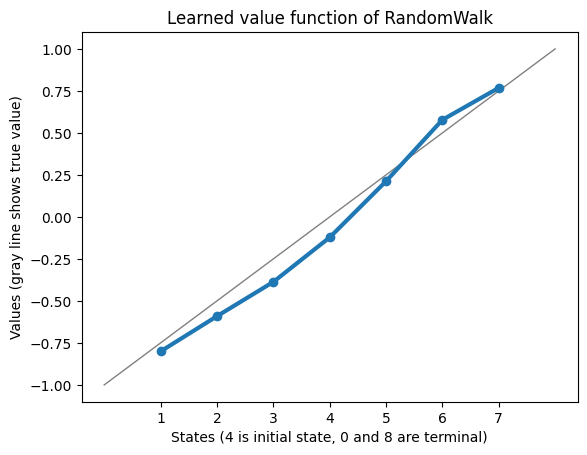

In [284]:
fig, ax = plt.subplots()

ax.plot([0, env.n_states - 1], [-1, 1], color="gray", linewidth=1)

X = np.arange(1, env.n_states - 1)
Y = vs[1:-1]
ax.plot(X, Y, marker="o", linewidth=3)
ax.set_title("Learned value function of RandomWalk")
ax.set_xlabel(
    f"States ({env.n_states//2} is initial state, 0 and {env.n_states-1} are terminal)"
)
ax.set_xticks(X)
ax.set_ylabel("Values (gray line shows true value)")

plt.show()

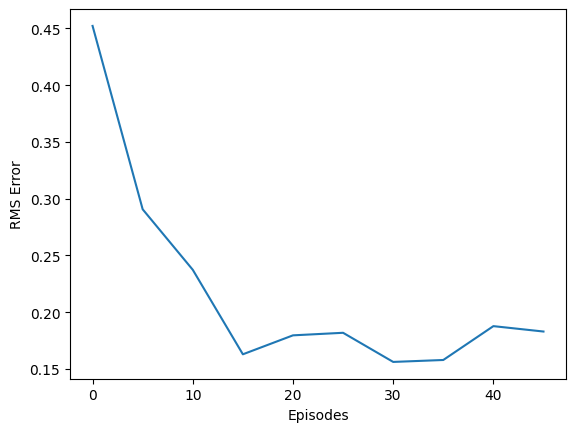

In [285]:
fig, ax = plt.subplots()

X = np.arange(0, episodes, record_err_per)
Y = rmse

ax.plot(X, Y)
ax.set_xlabel("Episodes")
ax.set_ylabel("RMS Error")

plt.show()